100%|██████████| 60/60 [41:30<00:00, 41.51s/it]


C:\Users\Rodrigo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.



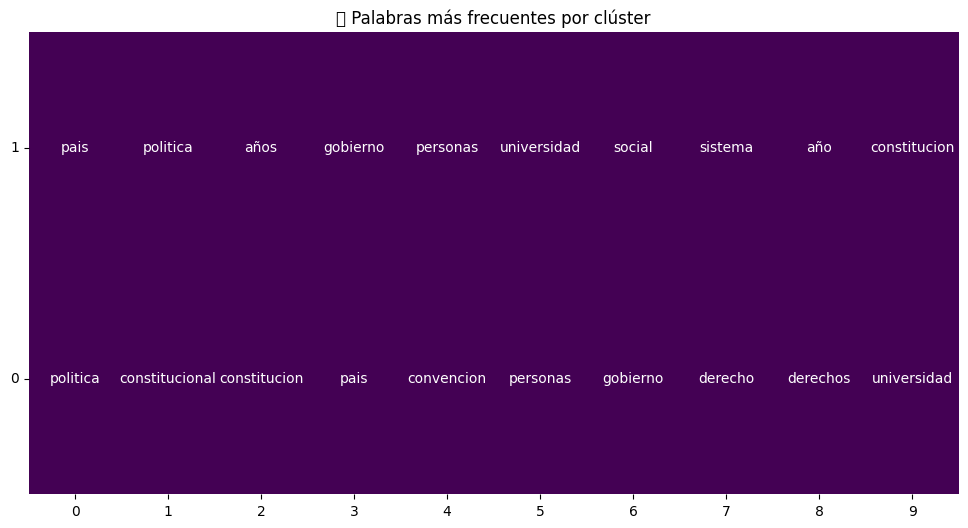

In [ ]:

import pandas as pd
import numpy as np
from datetime import datetime
import re
from tqdm import tqdm
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import community as community_louvain
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_parquet("01_bbdd_think_tanks.parquet")
df = df[(df["FechaPublicacion"] >= "2019-01-01") & (df["FechaPublicacion"] <= "2023-12-31")]
df["Mes"] = df["FechaPublicacion"].dt.to_period("M")

with open("stopwords.txt", "r", encoding="utf-8") as f:
    stopwords_custom = set(line.strip().lower() for line in f if line.strip())


def preprocess(text):
    text = re.sub(r"[^a-zA-ZáéíóúüñÁÉÍÓÚÜÑ\s]", "", text.lower())
    return [w for w in text.split() if len(w) > 2 and w not in stopwords_custom]

df["tokens"] = df["TextoLimpio"].dropna().apply(preprocess)


global_texts = df["tokens"].tolist()
global_dict = Dictionary(global_texts)
global_dict.filter_extremes(no_below=5, no_above=0.5)


def best_lda_model(texts, dictionary, corpus, min_topics=3, max_topics=5):
    best_model, best_coherence = None, -1
    for k in range(min_topics, max_topics + 1):
        lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=k, random_state=42)
        cm = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence = cm.get_coherence()
        if coherence > best_coherence:
            best_model, best_coherence = lda, coherence
    return best_model


topics_all = []
for mes, grupo in tqdm(df.groupby("Mes")):
    textos = grupo["tokens"].dropna().tolist()
    if not textos:
        continue
    corpus = [global_dict.doc2bow(text) for text in textos]
    if not corpus or all(len(doc) == 0 for doc in corpus):
        continue
    lda = best_lda_model(textos, global_dict, corpus)
    for idx, topic in enumerate(lda.show_topics(num_words=10, formatted=False)):
        palabras = [w for w, _ in topic[1]]
        vector = np.zeros(len(global_dict))
        for w_id, prob in lda.get_topic_terms(idx, topn=len(global_dict)):
            vector[w_id] = prob
        topics_all.append({
            "mes": str(mes),
            "topico_id": idx,
            "palabras": ", ".join(palabras),
            "vector": vector,
            "peso": np.mean([prob[idx] for prob in lda.get_document_topics(corpus, minimum_probability=0)]),
        })

df_topics = pd.DataFrame(topics_all)

# Similarity Graph + Louvain Clustering
G = nx.Graph()
similarity_threshold = 0.6
for i1, row1 in df_topics.iterrows():
    for i2, row2 in df_topics.iterrows():
        if i1 >= i2:
            continue
        sim = cosine_similarity([row1["vector"]], [row2["vector"]])[0][0]
        if sim > similarity_threshold:
            G.add_edge(i1, i2, weight=sim)
partition = community_louvain.best_partition(G)
df_topics["cluster"] = df_topics.index.map(partition)


df_plot = df_topics.copy()
df_plot["Mes"] = pd.to_datetime(df_plot["mes"])
fig = px.scatter(
    df_plot,
    x="Mes",
    y="peso",
    color="cluster",
    hover_data=["palabras"],
    title="📈 Evolución de Tópicos Emergentes en el Tiempo",
    labels={"peso": "Importancia del Tópico", "Mes": "Fecha"},
    template="plotly_white"
)
fig.update_traces(marker=dict(size=10, line=dict(width=0.5, color='DarkSlateGrey')))
fig.update_layout(legend_title_text='Clúster de Tópico')
fig.show()


timeline_df = df_topics.copy()
timeline_df["Mes"] = pd.to_datetime(timeline_df["mes"])
timeline_df = timeline_df.groupby(["Mes", "cluster"]).agg({"peso": "sum"}).reset_index()

fig2 = px.line(
    timeline_df,
    x="Mes",
    y="peso",
    color="cluster",
    title="📊 Línea de Tiempo por Clúster de Tópicos",
    labels={"peso": "Peso Total", "Mes": "Fecha"},
    markers=True,
    template="plotly_white"
)
fig2.show()


from collections import Counter
def top_words_por_cluster(df, top_n=10):
    cluster_words = {}
    for cluster in df["cluster"].unique():
        textos = df[df["cluster"] == cluster]["palabras"]
        all_words = [w for txt in textos for w in txt.split(", ")]
        counter = Counter(all_words)
        cluster_words[cluster] = [w for w, _ in counter.most_common(top_n)]
    return pd.DataFrame.from_dict(cluster_words, orient="index")

heatmap_df = top_words_por_cluster(df_topics, top_n=10)
plt.figure(figsize=(12, 6))
sns.heatmap(
    pd.DataFrame([[1]*10]*len(heatmap_df), index=heatmap_df.index, columns=heatmap_df.columns),
    cbar=False,
    annot=heatmap_df.values,
    fmt="",
    cmap="viridis"
)
plt.title("🔥 Palabras más frecuentes por clúster")
plt.yticks(rotation=0)
plt.show()



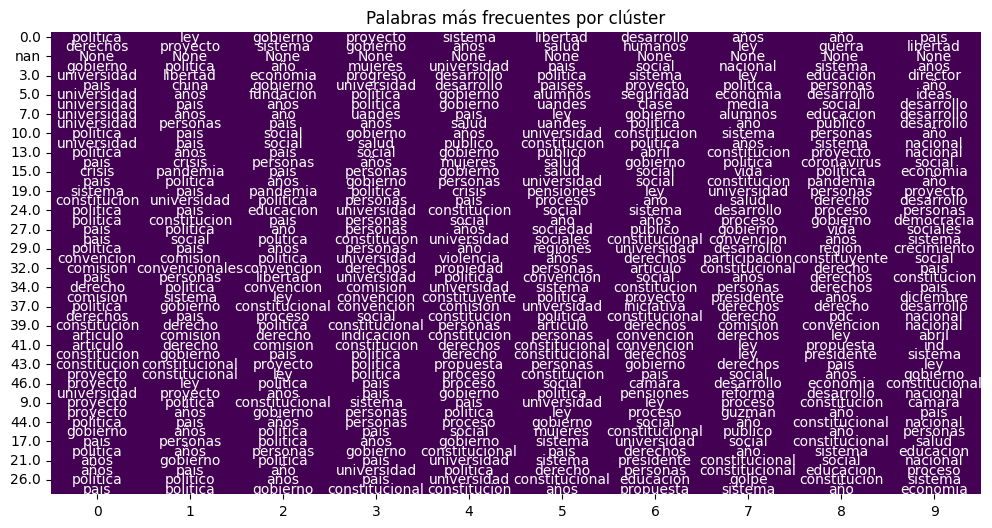

In [21]:
# -- Step 7: Similarity Graph + Louvain Clustering
G = nx.Graph()
similarity_threshold = 0.9
for i1, row1 in df_topics.iterrows():
    for i2, row2 in df_topics.iterrows():
        if i1 >= i2:
            continue
        sim = cosine_similarity([row1["vector"]], [row2["vector"]])[0][0]
        if sim > similarity_threshold:
            G.add_edge(i1, i2, weight=sim)
partition = community_louvain.best_partition(G)
df_topics["cluster"] = df_topics.index.map(partition)

# -- Step 8: Plotly Scatter of Topic Evolution
df_plot = df_topics.copy()
df_plot["Mes"] = pd.to_datetime(df_plot["mes"])
fig = px.scatter(
    df_plot,
    x="Mes",
    y="peso",
    color="cluster",
    hover_data=["palabras"],
    title="Evolución de Tópicos Emergentes en el Tiempo",
    labels={"peso": "Importancia del Tópico", "Mes": "Fecha"},
    template="plotly_white"
)
fig.update_traces(marker=dict(size=10, line=dict(width=0.5, color='DarkSlateGrey')))
fig.update_layout(legend_title_text='Clúster de Tópico')
fig.show()

# -- Step 9: Topic Timelines
timeline_df = df_topics.copy()
timeline_df["Mes"] = pd.to_datetime(timeline_df["mes"])
timeline_df = timeline_df.groupby(["Mes", "cluster"]).agg({"peso": "sum"}).reset_index()

fig2 = px.line(
    timeline_df,
    x="Mes",
    y="peso",
    color="cluster",
    title="Línea de Tiempo por Clúster de Tópicos",
    labels={"peso": "Peso Total", "Mes": "Fecha"},
    markers=True,
    template="plotly_white"
)
fig2.show()

# -- Step 10: Heatmap de palabras más representativas por clúster
from collections import Counter
def top_words_por_cluster(df, top_n=10):
    cluster_words = {}
    for cluster in df["cluster"].unique():
        textos = df[df["cluster"] == cluster]["palabras"]
        all_words = [w for txt in textos for w in txt.split(", ")]
        counter = Counter(all_words)
        cluster_words[cluster] = [w for w, _ in counter.most_common(top_n)]
    return pd.DataFrame.from_dict(cluster_words, orient="index")

heatmap_df = top_words_por_cluster(df_topics, top_n=10)
plt.figure(figsize=(12, 6))
sns.heatmap(
    pd.DataFrame([[1]*10]*len(heatmap_df), index=heatmap_df.index, columns=heatmap_df.columns),
    cbar=False,
    annot=heatmap_df.values,
    fmt="",
    cmap="viridis"
)
plt.title("Palabras más frecuentes por clúster")
plt.yticks(rotation=0)
plt.show()

In [15]:
df_topics.to_parquet("lda_topics_month.parquet", index=False)

In [16]:
df_topics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mes        233 non-null    object 
 1   topico_id  233 non-null    int64  
 2   palabras   233 non-null    object 
 3   vector     233 non-null    object 
 4   peso       233 non-null    float64
 5   cluster    233 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 11.1+ KB


In [9]:
import plotly.io as pio

nombres = ["grafico_evolucion_temas", "grafico_linea_temas"]
figuras = [fig, fig2]

for nombre, fig in zip(nombres, figuras):
    pio.write_html(
        fig, 
        file=f"{nombre}_fragmento.html", 
        full_html=False, 
        include_plotlyjs=False
    )


In [11]:
plotly_js_cdn = '<script src="https://cdn.plot.ly/plotly-latest.min.js"></script>'

html_parts = [f"<!DOCTYPE html><html><head>{plotly_js_cdn}<meta charset='utf-8'><title>Dashboard de Tópicos</title></head><body>"]
html_parts.append("<h1 style='text-align:center;'>Tópicos Think Tanks 2019-2023</h1>")

for nombre in nombres:
    html_parts.append(f"<h2>{nombre.replace('_', ' ').title()}</h2>")
    with open(f"{nombre}_fragmento.html", "r", encoding="utf-8") as f:
        html_parts.append(f.read())

html_parts.append("</body></html>")

# Escribir archivo final
with open("dashboard_frankenstein.html", "w", encoding="utf-8") as f:
    f.write("\n".join(html_parts))
